In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#from utility.utils import *

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

C:\Users\narendran.thesma\AppData\Local\Continuum\anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
torch.backends.cudnn.benchmark=False

In [5]:
PATH = Path('data/kaggle/TGS-Salt/')
paths = list(PATH.iterdir())
paths

[WindowsPath('data/kaggle/TGS-Salt/.ipynb_checkpoints'),
 WindowsPath('data/kaggle/TGS-Salt/depths.csv'),
 WindowsPath('data/kaggle/TGS-Salt/keras.model'),
 WindowsPath('data/kaggle/TGS-Salt/models'),
 WindowsPath('data/kaggle/TGS-Salt/sample_submission.csv'),
 WindowsPath('data/kaggle/TGS-Salt/Start.ipynb'),
 WindowsPath('data/kaggle/TGS-Salt/test'),
 WindowsPath('data/kaggle/TGS-Salt/tmp'),
 WindowsPath('data/kaggle/TGS-Salt/train'),
 WindowsPath('data/kaggle/TGS-Salt/train.csv')]

In [6]:
TRAIN_DN = 'train' 
TEST_DN = 'test'

In [7]:
masks_csv = pd.read_csv("data/kaggle/TGS-Salt/train.csv")
masks_csv.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [8]:
list((PATH/TRAIN_DN).iterdir())[:5]

[WindowsPath('data/kaggle/TGS-Salt/train/images'),
 WindowsPath('data/kaggle/TGS-Salt/train/masks')]

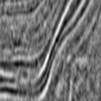

In [9]:
ID = 'a266a2a9df'
Image.open(PATH/TRAIN_DN/f'images/{ID}.png')

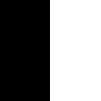

In [10]:
ID = 'a266a2a9df'
Image.open(PATH/TRAIN_DN/f'masks/{ID}.png')

In [11]:
IMAGE_IDS = [str(TRAIN_DIR).split('\\')[5] for TRAIN_DIR in list((PATH/TRAIN_DN/'images').iterdir())]

In [12]:
ims = [open_image(PATH/TRAIN_DN/f'images/{IMAGE_ID}.png')
       for IMAGE_ID in masks_csv['id']]

In [13]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

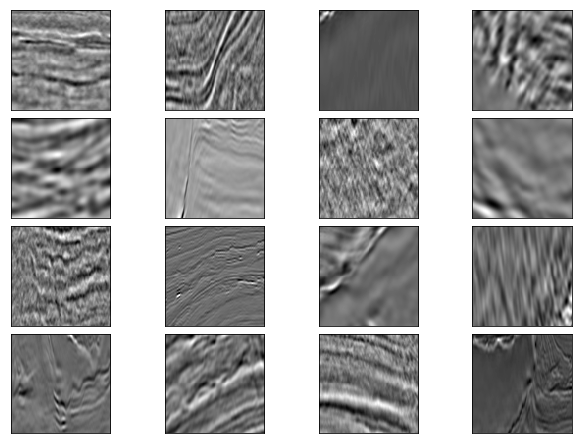

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

In [15]:
# TOTAL NUMBER OF IMAGES WITH MASK LABELS
n = len(list((PATH/TRAIN_DN/'images').iterdir()))
n

4000

In [16]:
TRAIN_DN = Path('data/kaggle/TGS-Salt/train/')
TEST_DN = Path('data/kaggle/TGS-Salt/train/')

In [17]:
TRAIN_DIRS = list(TRAIN_DN.iterdir())
TEST_DIRS = list(TEST_DN.iterdir())

In [18]:
class FilesDataset(BaseDataset):
    def __init__(self, fnames, transform, path):
        self.path,self.fnames = path,fnames
        super().__init__(transform)
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_n(self): return len(self.fnames)

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [19]:
test_im = cv2.imread(str(TEST_DN/f'images/{ID}.png'), cv2.IMREAD_GRAYSCALE)

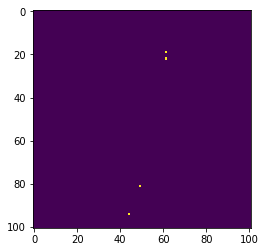

In [20]:
plt.imshow((test_im == 215)*1)

In [22]:
def get_multi_y(y, y_sz = None):
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    multi_y = np.dstack([(y == 30)*1, # back
    (y == 110)*1, # fore
    (y == 215)*1]).transpose(2,0,1) # bound
    if y_sz is not None:
        multi_y = np.array([cv2.resize(y.astype(np.uint8), (y_sz, y_sz)) for y in multi_y])
    return multi_y.astype(np.float32)

class NucleiDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path, y_sz=128):
        self.y_sz = y_sz
        self.y=y
        super().__init__(fnames, transform, path)
    def get_y(self, i): return get_multi_y(self.y[i], self.y_sz)
    def get_c(self): return 0

In [23]:
TRAIN_X = [str(f'train/images/{x_name}.png') for x_name in masks_csv['id']]
TRAIN_Y = [str(f'train/masks/{y_name}.png') for y_name in masks_csv['id']]

In [24]:
sample_submission = pd.read_csv('data/kaggle/TGS-Salt/sample_submission.csv')
TEST_X = [str(f'test/{x_name}.png') for x_name in sample_submission['id']]
TEST_Y = np.random.choice(TRAIN_Y, len(TEST_X))

In [108]:
VAL_X = np.array(TRAIN_X[3789:3799])
VAL_Y = np.array(TRAIN_Y[3789:3799])
TRN_X  = np.array(TRAIN_X[3800:])
TRN_Y = np.array(TRAIN_Y[3800:])

In [109]:
len(TRN_X), len(TRN_Y), len(VAL_X), len(VAL_Y), len(TEST_X), len(TEST_Y)

(200, 200, 10, 10, 18000, 18000)

In [110]:
VAL_X

array(['train/images/ce16b0d0bc.png', 'train/images/f28b483859.png', 'train/images/b9a7c521ac.png',
       'train/images/c749d05181.png', 'train/images/a5833d6cc4.png', 'train/images/cd2046479c.png',
       'train/images/ca84b9e8d4.png', 'train/images/8b5757d8ee.png', 'train/images/37aa9fc79a.png',
       'train/images/84e305da04.png'], dtype='<U27')

In [111]:
# set model function
PATH = 'data/kaggle/TGS-Salt/'
f = resnet18
sz = 128
bs = 1

In [112]:
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats
dataset = ImageData.get_ds(NucleiDataset, (TRN_X, TRN_Y), (VAL_X, VAL_Y), tfms=tfms, test= (TEST_X, TEST_Y), path=PATH)
md = ImageData(PATH, dataset, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [113]:
x,y = next(iter(md.trn_dl))
x_np, y_np = to_np(x[0]), to_np(y[0])

In [114]:
x_np.min(), x_np.max()

(-2.117904, 2.6202457)

In [115]:
open_image(f'{PATH}/{TRN_X[0]}').max()

1.0

In [116]:
y_np.min(), y_np.max()

(0.0, 0.0)

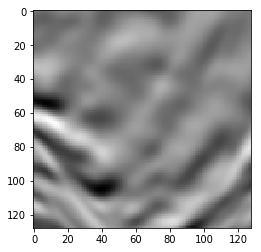

In [117]:
plt.imshow(denorm(x)[0])

In [118]:
#x,y = next(iter(md.val_dl))

In [119]:
x_np = to_np(x[0])

In [120]:
y_np = to_np(y[0])

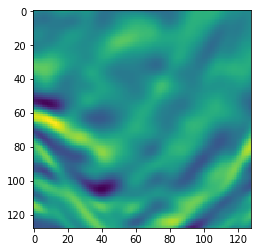

In [121]:
plt.imshow(x_np[1])

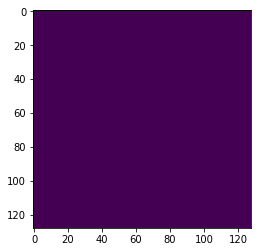

In [122]:
plt.imshow(y_np[2])

In [123]:
x = next(iter(md.test_dl))

In [124]:
from fastai.models.unet import *

In [125]:
# load defined model
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

In [126]:
f = resnet18
cut, cut_lr = model_meta[f]
cut, cut_lr

(8, 6)

In [127]:
encoder = get_encoder(f, cut)

In [128]:
m = DynamicUnet(encoder)

In [129]:
inp = torch.ones(1, 3, 128, 128)
out = (m(V(inp)))

In [130]:
m.sfs_idxs

[2, 4, 5, 6]

In [131]:
out.size()

torch.Size([1, 3, 128, 128])

In [132]:
inp.size()

torch.Size([1, 3, 128, 128])

In [133]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [134]:
# Wrap everything nicely
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [135]:
f = vgg16
cut, cut_lr = model_meta[f]
cut, cut_lr

(0, 22)

In [136]:
#models = UpsampleModel(m, cut_lr=20)

In [137]:
encoder = get_encoder(f, 30).cpu()

In [138]:
from fastai.models.unet import *
m = (DynamicUnet(encoder))
models = UpsampleModel(m,cut_lr)

In [139]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [140]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [141]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(1792))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(36928))])),
      

In [142]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 16, 16]),
 torch.Size([3, 512, 16, 16]),
 torch.Size([3, 512, 16, 16]),
 torch.Size([3, 512, 16, 16]),
 torch.Size([3, 512, 16, 16]),
 torch.Size([3, 512, 16, 16]),
 torch.Size([3, 512, 16, 16])]

In [ ]:
#m

In [143]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [144]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [145]:
learn.fit(lr,1,wds=wd,cycle_len=1,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.006725   0.000399   1.0        nan       


[0.0003991232515545562, 1.0, nan]

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=1,use_clr=(20,10))

In [ ]:
pred = learn.predict(is_test=True)

In [ ]:
pred = np.exp(pred)

In [ ]:
show_img(pred[125]>1);

In [ ]:
pred.shape

In [ ]:
from skimage.transform import resize
#x = resize(pred, (128, 128, 1), mode='constant', preserve_range=True)

preds_test_upsampled = []
for i in tnrange(len(pred)):
    preds_test_upsampled.append(resize(np.squeeze(pred[i]), 
                                       (101, 101), 
                                       mode='constant', preserve_range=True))

In [ ]:
preds_test_upsampled[0].shape

In [ ]:
show_img(preds_test_upsampled[125]>1);

In [ ]:
test_ids = test_csv['id']
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_Vgg.csv')

In [ ]:
len(sub)